In [1]:
q="jobname:*r7725.*"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=180)

In [3]:
ind="jobs2016"

ss = {
  "size": 0,
  "aggs": {
    "2": {
      "terms": {
        "field": "jobstatus", "size": 5,
        "order": { "_count": "desc" }
      },
      "aggs": {
        "3": { "avg": { "field": "wall_time"  }   },
        "4": { "avg": { "field": "nevents"  } },
        "5": { "avg": {   "field": "cpuconsumptiontime"  }  },
        "6": { "avg": { "field": "corecount" }  },
        "7": { "avg": { "field": "inputfilebytes" }  },
        "8": { "sum": {  "field": "inputfilebytes" }  }
      }
    }
  },
  "query": {
    "filtered": {
      "query": {  "query_string": { "analyze_wildcard": True, "lowercase_expanded_terms": False,  "query": q }  }
    }
  }
}

In [4]:
res= es.search( index=ind, body=ss, analyze_wildcard=True)

# print(res)
for r in res['aggregations']['2']['buckets']:
    cores=r['6']['value']
    wall=r['3']['value']
    events=r['4']['value']
    cpu=r['5']['value']

    if events<1: continue
    secPerEvent=wall/events*cores
    cpueff=cpu/(wall*cores)
    print (r['key'], "\tjobs:", r['doc_count'],"\tevents:", events, '\t avg.cores:', cores)
    print ("wall time:", wall, "\twalltime per event per core:", secPerEvent, "[s/ev/core]" ) 
    print ("cpu time :", cpu,  "\tcputtime per event:", cpu/events ,"\tcpu eff.:", cpueff ) 
    print ('--------------------------------------------------------')


finished 	jobs: 879383 	events: 2017.3294173301053 	 avg.cores: 7.99601984165793
wall time: 19272.49890207111 	walltime per event per core: 76.38974690769336 [s/ev/core]
cpu time : 96316.64187163045 	cputtime per event: 47.744627646933125 	cpu eff.: 0.6250135597991446
--------------------------------------------------------
failed 	jobs: 219356 	events: 694.0357045168585 	 avg.cores: 7.995915315742446
wall time: 14514.804928973905 	walltime per event per core: 167.2236028798966 [s/ev/core]
cpu time : 30332.026413683692 	cputtime per event: 43.70384148290877 	cpu eff.: 0.26134971816327723
--------------------------------------------------------
cancelled 	jobs: 4831 	events: 578.5551645622024 	 avg.cores: 8.0
wall time: 29111.923411302007 	walltime per event per core: 402.5465531305903 [s/ev/core]
cpu time : 65777.22769612916 	cputtime per event: 113.69223148479428 	cpu eff.: 0.28243250526085445
--------------------------------------------------------


In [5]:
ss = {
  "fields": ["wall_time","jobstatus"],
  "query": {
    "filtered": {
      "query": {  "query_string": { "analyze_wildcard": True, "lowercase_expanded_terms": False,  "query": q }  }
    }
  }
}

scroll = scan(es, query=ss, index=ind, scroll='10s')
fi=[]
fa=[]
for res in scroll:
    r = res['fields']
    if r['jobstatus'][0] == 'finished':
        fi.append(r['wall_time'][0]/3600)
    elif r['jobstatus'][0] == 'failed':
        fa.append(r['wall_time'][0]/3600)


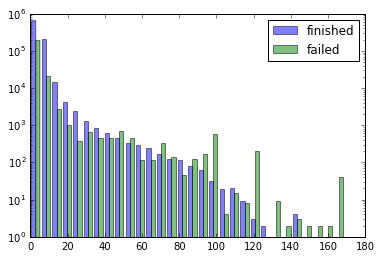

In [10]:
plt.hist([fi,fa],bins=30, log=True, alpha=0.5, stacked=False, label=['finished','failed'])
plt.legend(loc='upper right')
plt.show()